In [2]:
pip install wandb scipy seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import wandb
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines

In [2]:
# Initialize API
api = wandb.Api()

# Define workspace
workspace = "align_freeze"

# Define languages of interest
langs = ["same", "ar", "es", "fr", "ru", "zh", "af", "fa", "hi"]

# Function to fetch and process runs data created by a specific user
def fetch_and_process_runs(project, username="felixgaschi"):
    runs_data = {lang: [] for lang in langs}
    runs = api.runs(f"{workspace}/{project}")
    for run in runs:
        if run.user.username == username:  # Check if the run was created by the specified user
            for lang in langs:
                accuracy_key = f"eval_{lang}_accuracy"
                accuracy = run.summary.get(accuracy_key)
                if accuracy is not None:
                    runs_data[lang].append(accuracy)

    assert all([len(runs) == 5 for language, runs in runs_data.items()])
    return runs_data

In [3]:
# Function to create violin plots for deltas, one for each project pair, with confidence intervals
def plot_individual_violin_deltas_with_cis(project_pairs, langs, title=None):
    for baseline_project, align_freeze_project in project_pairs:
        # Fetch and process data
        baseline_data = fetch_and_process_runs(baseline_project)
        align_freeze_data = fetch_and_process_runs(align_freeze_project)

        # Initialize a list to store delta data for this pair
        delta_data = []

        # Compute deltas for each language
        for lang in langs:
            lang_deltas = [align_freeze - baseline for baseline, align_freeze in zip(baseline_data[lang], align_freeze_data[lang])]
            mean_delta = np.mean(lang_deltas)
            ci = scipy.stats.sem(lang_deltas) * scipy.stats.t.ppf((1 + 0.95) / 2., len(lang_deltas)-1)
            delta_data.extend([{'Language': lang, 'Delta': delta, 'Mean Delta': mean_delta, 'CI': ci} for delta in lang_deltas])

        # Convert collected data to a DataFrame
        df = pd.DataFrame(delta_data)

        # Plot settings
        plt.figure(figsize=(10, 6))
        ax = sns.violinplot(x='Language', y='Delta', data=df, inner='quartile', palette='coolwarm', dodge=False, hue='Language')
        ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])

        # Calculate the positions for the error bars
        # This will be the mean position of the violins for each language
        means = df.groupby('Language')['Delta'].mean().reindex(langs)
        cis = df.groupby('Language')['CI'].mean().reindex(langs)

        # Add error bars for confidence intervals
        error_bars = plt.errorbar(range(len(langs)), means, yerr=cis, fmt='o', color='black', capsize=5, label='Mean Delta ± CI')

        aligner_name = baseline_project.split('_')[-2]
        if aligner_name == 'dico':
            aligner_name = 'Bilingual Dictionaries'
        elif aligner_name == 'awesome':
            aligner_name = 'AwesomeAlign'
        elif aligner_name == 'fastalign':
            aligner_name = 'FastAlign'

        if title:
            plt.title(f'{title} - {aligner_name}')

        else:
            plt.title(f'Delta Accuracy (Align-Freeze minus Baseline) for {aligner_name} - Front Half Frozen')
        plt.axhline(0, color='grey', linewidth=0.8)  # Line to show where delta is zero
        plt.ylabel('Delta Accuracy')

        # Adjust the legend
        quartiles_median_line = mlines.Line2D([], [], color='black', linestyle='--', label='Quartiles/Median')
        mean_delta_ci_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Mean Delta ± CI')

        # Set the position of the legend
        ax.legend(handles=[quartiles_median_line, mean_delta_ci_line], loc='lower right', title="Legend")

        plt.tight_layout()
        plt.show()

/tmp/ipykernel_1076571/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


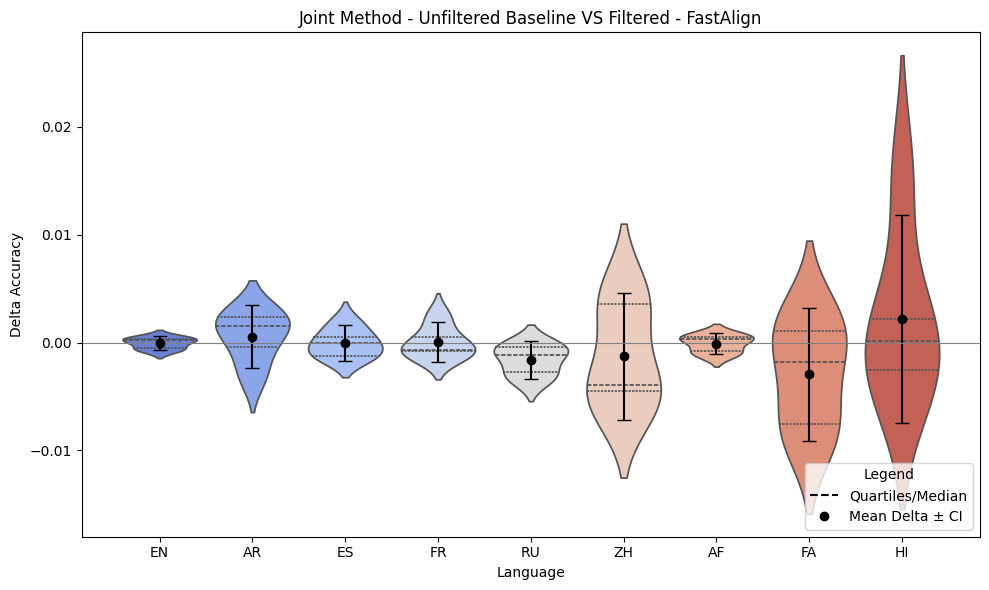

/tmp/ipykernel_1076571/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


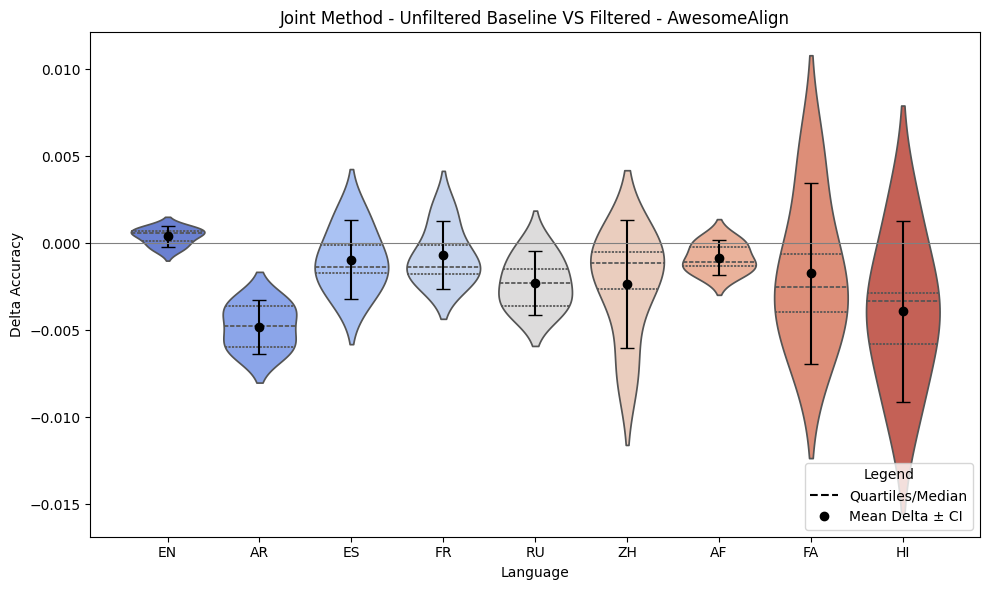

/tmp/ipykernel_1076571/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


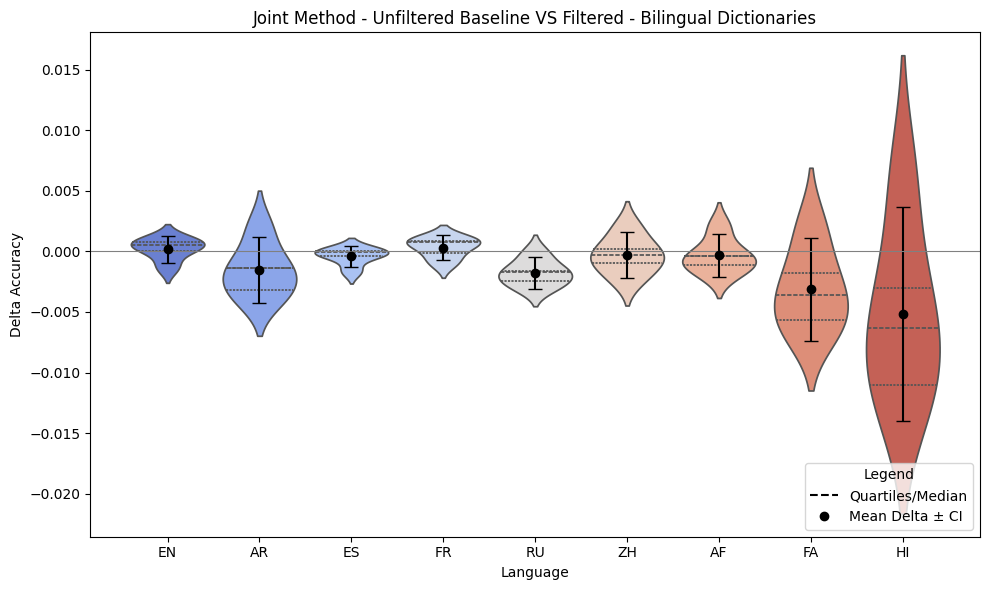

In [7]:
project_pairs = [
    ("3nl_during_fastalign_udpos", "3nl_filtered_0.7_during_fastalign_udpos"),
    ("3nl_during_awesome_udpos", "3nl_filtered_0.7_during_awesome_udpos"),
    ("3nl_during_dico_udpos", "3nl_filtered_0.7_during_dico_udpos")
]
plot_individual_violin_deltas_with_cis(project_pairs, langs, title='Joint Method - Unfiltered Baseline VS Filtered')

/tmp/ipykernel_1076571/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


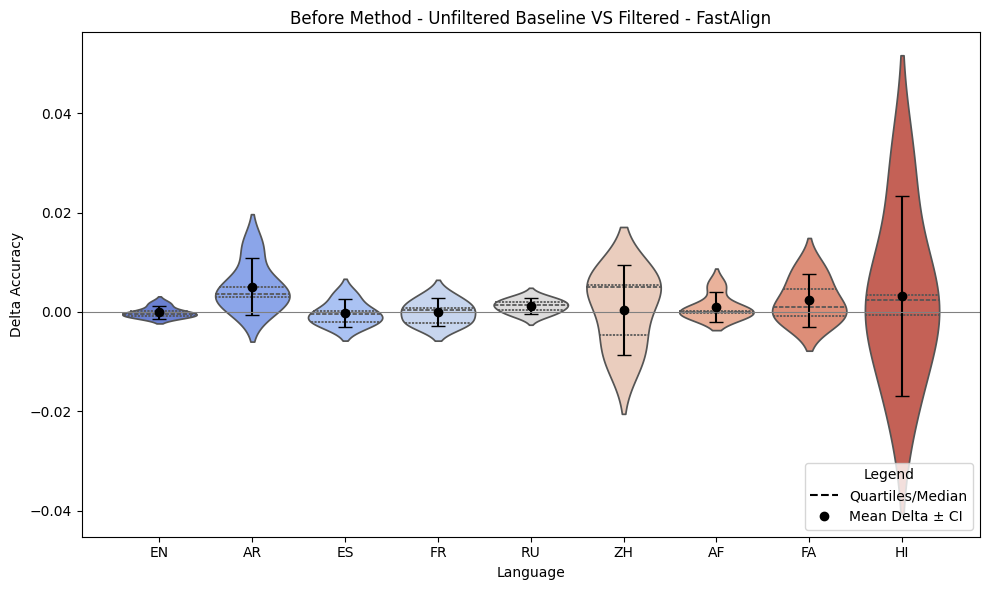

/tmp/ipykernel_1076571/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


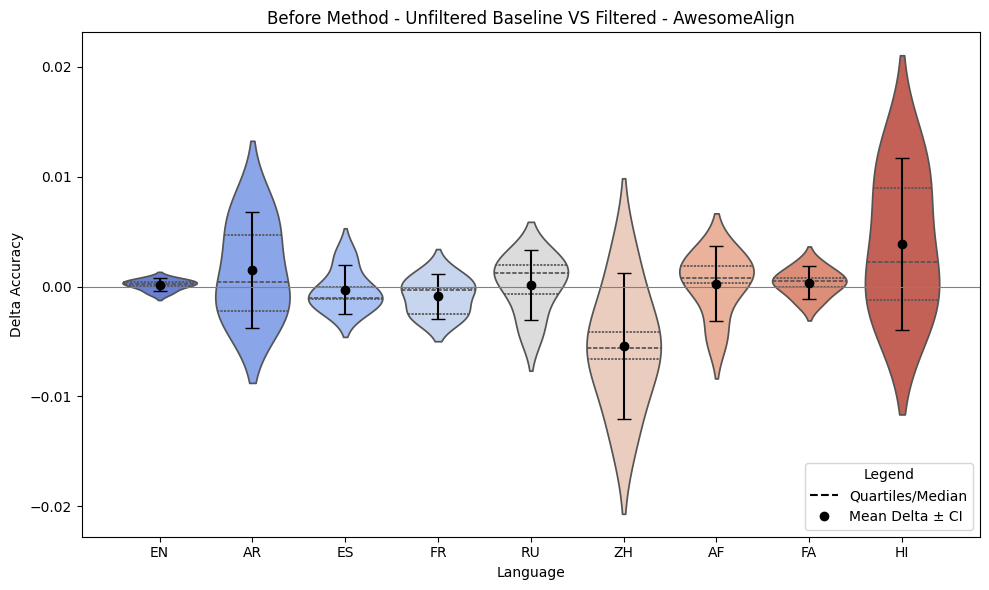

/tmp/ipykernel_1076571/3719560968.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


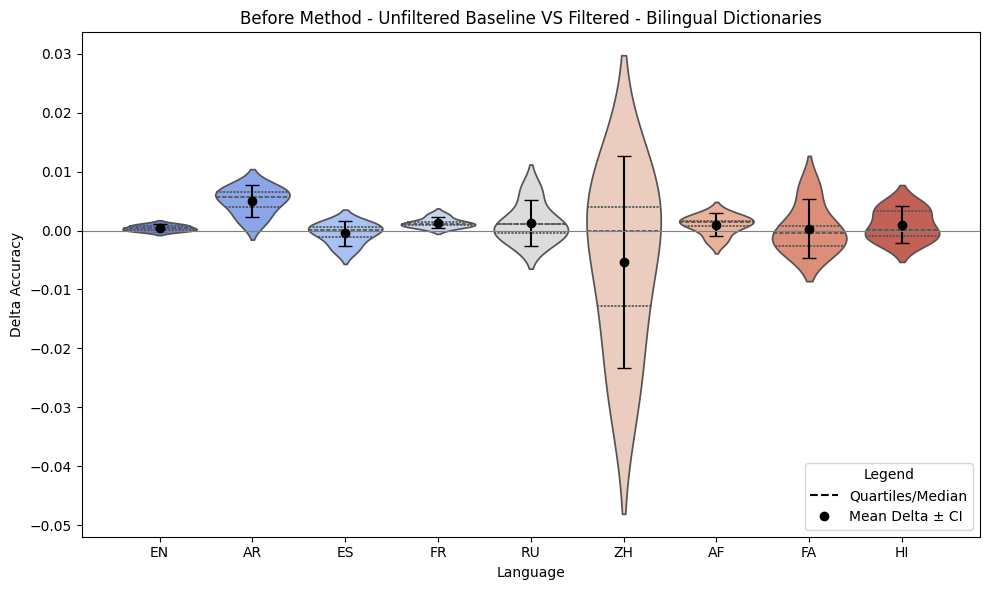

In [8]:
project_pairs = [
    ("3nl_before_fastalign_udpos", "3nl_filtered_0.7_before_fastalign_udpos"),
    ("3nl_before_awesome_udpos", "3nl_filtered_0.7_before_awesome_udpos"),
    ("3nl_before_dico_udpos", "3nl_filtered_0.7_before_dico_udpos")
]
plot_individual_violin_deltas_with_cis(project_pairs, langs, title='Before Method - Unfiltered Baseline VS Filtered')